### Import required python libraries

In [1]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RepeatedKFold
from ers.similarity_combination_element_lib import SimilarityCombinationElement, InstanceBasedClassifier

### Declare parameters of the notebook

In [2]:
OUTPUT_FOLDER = "../output/recommendation_CV/ASMI16"
INPUT_DATA = "../data/HEA_data.ASMI16.csv"
N_SPLITS = 9
N_REPEATS = 3
N_CANDIDATE = 311 # Number of unobserved combinations in each cv
SIMILARITY_VALUE = 0.2 # parameter alpha
MAX_SIZE_SUBSET = 1
SIZES = [2] # size of unobserved combination
ELEMENTS = [
    'Mn', 'Fe', 'Nb', 'Tc', 'Au', 'Ta', 'W', 'Zr', 'Ni',
    'Mo', 'Rh', 'Co', 'Ir', 'Re', 'Pd', 'Ru', 'Cu', 'Pt',
    'Ti', 'Os', 'Cr', 'Hf', 'V', 'Ag', 'Al', "Si", "As"
]

In [3]:
def generate_unobserved_combinations(df_data, elements, sizes=[2,3]):
    unobserved_combinations = []
    for size in sizes:
        for unobserved_combination in itertools.combinations(elements, size):
            query = " == 1 & ".join(unobserved_combination) + " == 1 & length == {}".format(len(unobserved_combination))
            df_tmp = df_data.query(query)
            if len(df_tmp.index) == 0:
                unobserved_combinations.append("|".join(unobserved_combination))
    return unobserved_combinations

In [4]:
def report_recommendation_results(unobserved_combinations, final_decisions, df_test):
    # Ranking unobserved combination using the m({HEA})
    results = []
    for material, final_decision in zip(unobserved_combinations, final_decisions):
        results.append([
            material, final_decision[frozenset({"High"})], final_decision[frozenset({"Low"})],
            final_decision[frozenset({"High", "Low"})], "High" if final_decision[frozenset({"High"})] > final_decision[frozenset({"Low"})] else "Low"
        ])

    df_recommend = pd.DataFrame(results, columns=["materials", "DST_High", "DST_Low", "DST_Uncertainty", "Label"])
    df_ranking = df_recommend.sort_values(by=["DST_High", "DST_Uncertainty"], ascending=[False, True])

    # Save the recommendation results of HEA in test set
    results = []
    index = 1
    for ith, row in df_ranking.iterrows():
        elements = row["materials"].split("|")
        df_tmp = df_test.query(" == 1 & ".join(elements) + " == 1 & length == {}".format(len(elements)))
        if len(df_tmp.index) == 1:
            tmp_row = list(row.values.copy())
            tmp_row.append(index)
            results.append(tmp_row)
        index += 1
    return pd.DataFrame(results, columns=["materials", "DST_High", "DST_Low", "DST_Uncertainty", "Label", "index"])


### Load data set

In [5]:
df_data = pd.read_csv(INPUT_DATA, index_col=0)
df_data.head(10)

,combination,Ag,Al,As,Au,Co,Cr,Cu,Fe,Hf,...,Si,Ta,Tc,Ti,V,W,Zr,Label,set_name,length
0,AuNi,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,High,Au|Ni,2
1,AuPt,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,High,Au|Pt,2
2,AuV,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,High,Au|V,2
3,CoMn,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,High,Co|Mn,2
4,CoNi,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,High,Co|Ni,2
5,CoPt,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,High,Co|Pt,2
6,CrFe,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,High,Cr|Fe,2
7,CrMn,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,High,Cr|Mn,2
8,CrPt,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,High,Cr|Pt,2
9,CrTa,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,High,Cr|Ta,2


### Evaluate the recommendation performance of the ERS using cross-validation

In [6]:
kf = RepeatedKFold(n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=1)
for index_model, (train, test) in enumerate(kf.split(df_data.index.values)):
    print("==========CV {}==========".format(index_model))
    df_data_train = df_data.loc[train]
    df_data_test = df_data.loc[test]
    
    similarity_combination_element = SimilarityCombinationElement(
        df_data=df_data, similarity_value=SIMILARITY_VALUE, rage_size_subset=MAX_SIZE_SUBSET
    )
    similarity_combination_element.similarity_measurement()
    df_similarity = similarity_combination_element.df_similarity
    df_dissimilarity = similarity_combination_element.df_dissimilarity
    df_uncertainty = similarity_combination_element.df_uncertainty
    classifier = InstanceBasedClassifier(
        df_data, df_similarity, df_dissimilarity, 
        df_uncertainty, n_gram_evidence=1
    )
    
    unobserved_combinations = generate_unobserved_combinations(
        df_data=df_data_train, elements=ELEMENTS, sizes=SIZES
    )
    
    y_pred, final_decisions = classifier.predict(
        np.array(unobserved_combinations), show_decision=True
    )
    
    df_result = report_recommendation_results(
        unobserved_combinations, final_decisions, df_data_test
    )
    df_result.to_csv("{}/high_recommend_model_{}.csv".format(OUTPUT_FOLDER, index_model))



==========CV 0==========
Evaluate () and ('Cr',)
Evaluate () and ('Hf',)
Evaluate () and ('Co',)
Evaluate () and ('Cu',)
Evaluate () and ('Ti',)
Evaluate () and ('Mo',)
Evaluate () and ('Fe',)
Evaluate () and ('Zr',)
Evaluate () and ('Mn',)
Evaluate () and ('Ir',)
Evaluate () and ('Nb',)
Evaluate () and ('Au',)
Evaluate () and ('Pd',)
Evaluate () and ('Ta',)
Evaluate () and ('Ni',)
Evaluate () and ('V',)
Evaluate () and ('Pt',)
Evaluate () and ('W',)
Evaluate () and ('Rh',)
Evaluate ('Cr',) and ('Hf',)
Evaluate ('Cr',) and ('Co',)
Evaluate ('Cr',) and ('Cu',)
Evaluate ('Cr',) and ('Ti',)
Evaluate ('Cr',) and ('Mo',)
Evaluate ('Cr',) and ('Fe',)
Evaluate ('Cr',) and ('Zr',)
Evaluate ('Cr',) and ('Mn',)
Evaluate ('Cr',) and ('Ir',)
Evaluate ('Cr',) and ('Nb',)
Evaluate ('Cr',) and ('Au',)
Evaluate ('Cr',) and ('Pd',)
Evaluate ('Cr',) and ('Ta',)
Evaluate ('Cr',) and ('Ni',)
Evaluate ('Cr',) and ('V',)
Evaluate ('Cr',) and ('Pt',)
Evaluate ('Cr',) and ('W',)
Evaluate ('Cr',) and ('Rh',)
E

Evaluate ('Mo',) and ('Ir',)
Evaluate ('Mo',) and ('Nb',)
Evaluate ('Mo',) and ('Au',)
Evaluate ('Mo',) and ('Pd',)
Evaluate ('Mo',) and ('Ta',)
Evaluate ('Mo',) and ('Ni',)
Evaluate ('Mo',) and ('V',)
Evaluate ('Mo',) and ('Pt',)
Evaluate ('Mo',) and ('W',)
Evaluate ('Mo',) and ('Rh',)
Evaluate ('Fe',) and ('Zr',)
Evaluate ('Fe',) and ('Mn',)
Evaluate ('Fe',) and ('Ir',)
Evaluate ('Fe',) and ('Nb',)
Evaluate ('Fe',) and ('Au',)
Evaluate ('Fe',) and ('Pd',)
Evaluate ('Fe',) and ('Ta',)
Evaluate ('Fe',) and ('Ni',)
Evaluate ('Fe',) and ('V',)
Evaluate ('Fe',) and ('Pt',)
Evaluate ('Fe',) and ('W',)
Evaluate ('Fe',) and ('Rh',)
Evaluate ('Zr',) and ('Mn',)
Evaluate ('Zr',) and ('Ir',)
Evaluate ('Zr',) and ('Nb',)
Evaluate ('Zr',) and ('Au',)
Evaluate ('Zr',) and ('Pd',)
Evaluate ('Zr',) and ('Ta',)
Evaluate ('Zr',) and ('Ni',)
Evaluate ('Zr',) and ('V',)
Evaluate ('Zr',) and ('Pt',)
Evaluate ('Zr',) and ('W',)
Evaluate ('Zr',) and ('Rh',)
Evaluate ('Mn',) and ('Ir',)
Evaluate ('Mn',) and

Evaluate () and ('V',)
Evaluate () and ('Pt',)
Evaluate () and ('W',)
Evaluate () and ('Rh',)
Evaluate ('Cr',) and ('Hf',)
Evaluate ('Cr',) and ('Co',)
Evaluate ('Cr',) and ('Cu',)
Evaluate ('Cr',) and ('Ti',)
Evaluate ('Cr',) and ('Mo',)
Evaluate ('Cr',) and ('Fe',)
Evaluate ('Cr',) and ('Zr',)
Evaluate ('Cr',) and ('Mn',)
Evaluate ('Cr',) and ('Ir',)
Evaluate ('Cr',) and ('Nb',)
Evaluate ('Cr',) and ('Au',)
Evaluate ('Cr',) and ('Pd',)
Evaluate ('Cr',) and ('Ta',)
Evaluate ('Cr',) and ('Ni',)
Evaluate ('Cr',) and ('V',)
Evaluate ('Cr',) and ('Pt',)
Evaluate ('Cr',) and ('W',)
Evaluate ('Cr',) and ('Rh',)
Evaluate ('Hf',) and ('Co',)
Evaluate ('Hf',) and ('Cu',)
Evaluate ('Hf',) and ('Ti',)
Evaluate ('Hf',) and ('Mo',)
Evaluate ('Hf',) and ('Fe',)
Evaluate ('Hf',) and ('Zr',)
Evaluate ('Hf',) and ('Mn',)
Evaluate ('Hf',) and ('Ir',)
Evaluate ('Hf',) and ('Nb',)
Evaluate ('Hf',) and ('Au',)
Evaluate ('Hf',) and ('Pd',)
Evaluate ('Hf',) and ('Ta',)
Evaluate ('Hf',) and ('Ni',)
Evaluate 

Evaluate ('Fe',) and ('Ir',)
Evaluate ('Fe',) and ('Nb',)
Evaluate ('Fe',) and ('Au',)
Evaluate ('Fe',) and ('Pd',)
Evaluate ('Fe',) and ('Ta',)
Evaluate ('Fe',) and ('Ni',)
Evaluate ('Fe',) and ('V',)
Evaluate ('Fe',) and ('Pt',)
Evaluate ('Fe',) and ('W',)
Evaluate ('Fe',) and ('Rh',)
Evaluate ('Zr',) and ('Mn',)
Evaluate ('Zr',) and ('Ir',)
Evaluate ('Zr',) and ('Nb',)
Evaluate ('Zr',) and ('Au',)
Evaluate ('Zr',) and ('Pd',)
Evaluate ('Zr',) and ('Ta',)
Evaluate ('Zr',) and ('Ni',)
Evaluate ('Zr',) and ('V',)
Evaluate ('Zr',) and ('Pt',)
Evaluate ('Zr',) and ('W',)
Evaluate ('Zr',) and ('Rh',)
Evaluate ('Mn',) and ('Ir',)
Evaluate ('Mn',) and ('Nb',)
Evaluate ('Mn',) and ('Au',)
Evaluate ('Mn',) and ('Pd',)
Evaluate ('Mn',) and ('Ta',)
Evaluate ('Mn',) and ('Ni',)
Evaluate ('Mn',) and ('V',)
Evaluate ('Mn',) and ('Pt',)
Evaluate ('Mn',) and ('W',)
Evaluate ('Mn',) and ('Rh',)
Evaluate ('Ir',) and ('Nb',)
Evaluate ('Ir',) and ('Au',)
Evaluate ('Ir',) and ('Pd',)
Evaluate ('Ir',) and

Evaluate ('Cr',) and ('Au',)
Evaluate ('Cr',) and ('Pd',)
Evaluate ('Cr',) and ('Ta',)
Evaluate ('Cr',) and ('Ni',)
Evaluate ('Cr',) and ('V',)
Evaluate ('Cr',) and ('Pt',)
Evaluate ('Cr',) and ('W',)
Evaluate ('Cr',) and ('Rh',)
Evaluate ('Hf',) and ('Co',)
Evaluate ('Hf',) and ('Cu',)
Evaluate ('Hf',) and ('Ti',)
Evaluate ('Hf',) and ('Mo',)
Evaluate ('Hf',) and ('Fe',)
Evaluate ('Hf',) and ('Zr',)
Evaluate ('Hf',) and ('Mn',)
Evaluate ('Hf',) and ('Ir',)
Evaluate ('Hf',) and ('Nb',)
Evaluate ('Hf',) and ('Au',)
Evaluate ('Hf',) and ('Pd',)
Evaluate ('Hf',) and ('Ta',)
Evaluate ('Hf',) and ('Ni',)
Evaluate ('Hf',) and ('V',)
Evaluate ('Hf',) and ('Pt',)
Evaluate ('Hf',) and ('W',)
Evaluate ('Hf',) and ('Rh',)
Evaluate ('Co',) and ('Cu',)
Evaluate ('Co',) and ('Ti',)
Evaluate ('Co',) and ('Mo',)
Evaluate ('Co',) and ('Fe',)
Evaluate ('Co',) and ('Zr',)
Evaluate ('Co',) and ('Mn',)
Evaluate ('Co',) and ('Ir',)
Evaluate ('Co',) and ('Nb',)
Evaluate ('Co',) and ('Au',)
Evaluate ('Co',) a

Evaluate ('Zr',) and ('Ta',)
Evaluate ('Zr',) and ('Ni',)
Evaluate ('Zr',) and ('V',)
Evaluate ('Zr',) and ('Pt',)
Evaluate ('Zr',) and ('W',)
Evaluate ('Zr',) and ('Rh',)
Evaluate ('Mn',) and ('Ir',)
Evaluate ('Mn',) and ('Nb',)
Evaluate ('Mn',) and ('Au',)
Evaluate ('Mn',) and ('Pd',)
Evaluate ('Mn',) and ('Ta',)
Evaluate ('Mn',) and ('Ni',)
Evaluate ('Mn',) and ('V',)
Evaluate ('Mn',) and ('Pt',)
Evaluate ('Mn',) and ('W',)
Evaluate ('Mn',) and ('Rh',)
Evaluate ('Ir',) and ('Nb',)
Evaluate ('Ir',) and ('Au',)
Evaluate ('Ir',) and ('Pd',)
Evaluate ('Ir',) and ('Ta',)
Evaluate ('Ir',) and ('Ni',)
Evaluate ('Ir',) and ('V',)
Evaluate ('Ir',) and ('Pt',)
Evaluate ('Ir',) and ('W',)
Evaluate ('Ir',) and ('Rh',)
Evaluate ('Nb',) and ('Au',)
Evaluate ('Nb',) and ('Pd',)
Evaluate ('Nb',) and ('Ta',)
Evaluate ('Nb',) and ('Ni',)
Evaluate ('Nb',) and ('V',)
Evaluate ('Nb',) and ('Pt',)
Evaluate ('Nb',) and ('W',)
Evaluate ('Nb',) and ('Rh',)
Evaluate ('Au',) and ('Pd',)
Evaluate ('Au',) and (

Evaluate ('Hf',) and ('Mn',)
Evaluate ('Hf',) and ('Ir',)
Evaluate ('Hf',) and ('Nb',)
Evaluate ('Hf',) and ('Au',)
Evaluate ('Hf',) and ('Pd',)
Evaluate ('Hf',) and ('Ta',)
Evaluate ('Hf',) and ('Ni',)
Evaluate ('Hf',) and ('V',)
Evaluate ('Hf',) and ('Pt',)
Evaluate ('Hf',) and ('W',)
Evaluate ('Hf',) and ('Rh',)
Evaluate ('Co',) and ('Cu',)
Evaluate ('Co',) and ('Ti',)
Evaluate ('Co',) and ('Mo',)
Evaluate ('Co',) and ('Fe',)
Evaluate ('Co',) and ('Zr',)
Evaluate ('Co',) and ('Mn',)
Evaluate ('Co',) and ('Ir',)
Evaluate ('Co',) and ('Nb',)
Evaluate ('Co',) and ('Au',)
Evaluate ('Co',) and ('Pd',)
Evaluate ('Co',) and ('Ta',)
Evaluate ('Co',) and ('Ni',)
Evaluate ('Co',) and ('V',)
Evaluate ('Co',) and ('Pt',)
Evaluate ('Co',) and ('W',)
Evaluate ('Co',) and ('Rh',)
Evaluate ('Cu',) and ('Ti',)
Evaluate ('Cu',) and ('Mo',)
Evaluate ('Cu',) and ('Fe',)
Evaluate ('Cu',) and ('Zr',)
Evaluate ('Cu',) and ('Mn',)
Evaluate ('Cu',) and ('Ir',)
Evaluate ('Cu',) and ('Nb',)
Evaluate ('Cu',) a

Evaluate ('Mn',) and ('W',)
Evaluate ('Mn',) and ('Rh',)
Evaluate ('Ir',) and ('Nb',)
Evaluate ('Ir',) and ('Au',)
Evaluate ('Ir',) and ('Pd',)
Evaluate ('Ir',) and ('Ta',)
Evaluate ('Ir',) and ('Ni',)
Evaluate ('Ir',) and ('V',)
Evaluate ('Ir',) and ('Pt',)
Evaluate ('Ir',) and ('W',)
Evaluate ('Ir',) and ('Rh',)
Evaluate ('Nb',) and ('Au',)
Evaluate ('Nb',) and ('Pd',)
Evaluate ('Nb',) and ('Ta',)
Evaluate ('Nb',) and ('Ni',)
Evaluate ('Nb',) and ('V',)
Evaluate ('Nb',) and ('Pt',)
Evaluate ('Nb',) and ('W',)
Evaluate ('Nb',) and ('Rh',)
Evaluate ('Au',) and ('Pd',)
Evaluate ('Au',) and ('Ta',)
Evaluate ('Au',) and ('Ni',)
Evaluate ('Au',) and ('V',)
Evaluate ('Au',) and ('Pt',)
Evaluate ('Au',) and ('W',)
Evaluate ('Au',) and ('Rh',)
Evaluate ('Pd',) and ('Ta',)
Evaluate ('Pd',) and ('Ni',)
Evaluate ('Pd',) and ('V',)
Evaluate ('Pd',) and ('Pt',)
Evaluate ('Pd',) and ('W',)
Evaluate ('Pd',) and ('Rh',)
Evaluate ('Ta',) and ('Ni',)
Evaluate ('Ta',) and ('V',)
Evaluate ('Ta',) and ('P

Evaluate ('Co',) and ('Ti',)
Evaluate ('Co',) and ('Mo',)
Evaluate ('Co',) and ('Fe',)
Evaluate ('Co',) and ('Zr',)
Evaluate ('Co',) and ('Mn',)
Evaluate ('Co',) and ('Ir',)
Evaluate ('Co',) and ('Nb',)
Evaluate ('Co',) and ('Au',)
Evaluate ('Co',) and ('Pd',)
Evaluate ('Co',) and ('Ta',)
Evaluate ('Co',) and ('Ni',)
Evaluate ('Co',) and ('V',)
Evaluate ('Co',) and ('Pt',)
Evaluate ('Co',) and ('W',)
Evaluate ('Co',) and ('Rh',)
Evaluate ('Cu',) and ('Ti',)
Evaluate ('Cu',) and ('Mo',)
Evaluate ('Cu',) and ('Fe',)
Evaluate ('Cu',) and ('Zr',)
Evaluate ('Cu',) and ('Mn',)
Evaluate ('Cu',) and ('Ir',)
Evaluate ('Cu',) and ('Nb',)
Evaluate ('Cu',) and ('Au',)
Evaluate ('Cu',) and ('Pd',)
Evaluate ('Cu',) and ('Ta',)
Evaluate ('Cu',) and ('Ni',)
Evaluate ('Cu',) and ('V',)
Evaluate ('Cu',) and ('Pt',)
Evaluate ('Cu',) and ('W',)
Evaluate ('Cu',) and ('Rh',)
Evaluate ('Ti',) and ('Mo',)
Evaluate ('Ti',) and ('Fe',)
Evaluate ('Ti',) and ('Zr',)
Evaluate ('Ti',) and ('Mn',)
Evaluate ('Ti',) a

Evaluate ('Nb',) and ('Au',)
Evaluate ('Nb',) and ('Pd',)
Evaluate ('Nb',) and ('Ta',)
Evaluate ('Nb',) and ('Ni',)
Evaluate ('Nb',) and ('V',)
Evaluate ('Nb',) and ('Pt',)
Evaluate ('Nb',) and ('W',)
Evaluate ('Nb',) and ('Rh',)
Evaluate ('Au',) and ('Pd',)
Evaluate ('Au',) and ('Ta',)
Evaluate ('Au',) and ('Ni',)
Evaluate ('Au',) and ('V',)
Evaluate ('Au',) and ('Pt',)
Evaluate ('Au',) and ('W',)
Evaluate ('Au',) and ('Rh',)
Evaluate ('Pd',) and ('Ta',)
Evaluate ('Pd',) and ('Ni',)
Evaluate ('Pd',) and ('V',)
Evaluate ('Pd',) and ('Pt',)
Evaluate ('Pd',) and ('W',)
Evaluate ('Pd',) and ('Rh',)
Evaluate ('Ta',) and ('Ni',)
Evaluate ('Ta',) and ('V',)
Evaluate ('Ta',) and ('Pt',)
Evaluate ('Ta',) and ('W',)
Evaluate ('Ta',) and ('Rh',)
Evaluate ('Ni',) and ('V',)
Evaluate ('Ni',) and ('Pt',)
Evaluate ('Ni',) and ('W',)
Evaluate ('Ni',) and ('Rh',)
Evaluate ('V',) and ('Pt',)
Evaluate ('V',) and ('W',)
Evaluate ('V',) and ('Rh',)
Evaluate ('Pt',) and ('W',)
Evaluate ('Pt',) and ('Rh',)


Evaluate ('Co',) and ('Pt',)
Evaluate ('Co',) and ('W',)
Evaluate ('Co',) and ('Rh',)
Evaluate ('Cu',) and ('Ti',)
Evaluate ('Cu',) and ('Mo',)
Evaluate ('Cu',) and ('Fe',)
Evaluate ('Cu',) and ('Zr',)
Evaluate ('Cu',) and ('Mn',)
Evaluate ('Cu',) and ('Ir',)
Evaluate ('Cu',) and ('Nb',)
Evaluate ('Cu',) and ('Au',)
Evaluate ('Cu',) and ('Pd',)
Evaluate ('Cu',) and ('Ta',)
Evaluate ('Cu',) and ('Ni',)
Evaluate ('Cu',) and ('V',)
Evaluate ('Cu',) and ('Pt',)
Evaluate ('Cu',) and ('W',)
Evaluate ('Cu',) and ('Rh',)
Evaluate ('Ti',) and ('Mo',)
Evaluate ('Ti',) and ('Fe',)
Evaluate ('Ti',) and ('Zr',)
Evaluate ('Ti',) and ('Mn',)
Evaluate ('Ti',) and ('Ir',)
Evaluate ('Ti',) and ('Nb',)
Evaluate ('Ti',) and ('Au',)
Evaluate ('Ti',) and ('Pd',)
Evaluate ('Ti',) and ('Ta',)
Evaluate ('Ti',) and ('Ni',)
Evaluate ('Ti',) and ('V',)
Evaluate ('Ti',) and ('Pt',)
Evaluate ('Ti',) and ('W',)
Evaluate ('Ti',) and ('Rh',)
Evaluate ('Mo',) and ('Fe',)
Evaluate ('Mo',) and ('Zr',)
Evaluate ('Mo',) an

Evaluate ('Pd',) and ('Ta',)
Evaluate ('Pd',) and ('Ni',)
Evaluate ('Pd',) and ('V',)
Evaluate ('Pd',) and ('Pt',)
Evaluate ('Pd',) and ('W',)
Evaluate ('Pd',) and ('Rh',)
Evaluate ('Ta',) and ('Ni',)
Evaluate ('Ta',) and ('V',)
Evaluate ('Ta',) and ('Pt',)
Evaluate ('Ta',) and ('W',)
Evaluate ('Ta',) and ('Rh',)
Evaluate ('Ni',) and ('V',)
Evaluate ('Ni',) and ('Pt',)
Evaluate ('Ni',) and ('W',)
Evaluate ('Ni',) and ('Rh',)
Evaluate ('V',) and ('Pt',)
Evaluate ('V',) and ('W',)
Evaluate ('V',) and ('Rh',)
Evaluate ('Pt',) and ('W',)
Evaluate ('Pt',) and ('Rh',)
Evaluate ('W',) and ('Rh',)
==========CV 17==========
Evaluate () and ('Cr',)
Evaluate () and ('Hf',)
Evaluate () and ('Co',)
Evaluate () and ('Cu',)
Evaluate () and ('Ti',)
Evaluate () and ('Mo',)
Evaluate () and ('Fe',)
Evaluate () and ('Zr',)
Evaluate () and ('Mn',)
Evaluate () and ('Ir',)
Evaluate () and ('Nb',)
Evaluate () and ('Au',)
Evaluate () and ('Pd',)
Evaluate () and ('Ta',)
Evaluate () and ('Ni',)
Evaluate () and (

Evaluate ('Cu',) and ('V',)
Evaluate ('Cu',) and ('Pt',)
Evaluate ('Cu',) and ('W',)
Evaluate ('Cu',) and ('Rh',)
Evaluate ('Ti',) and ('Mo',)
Evaluate ('Ti',) and ('Fe',)
Evaluate ('Ti',) and ('Zr',)
Evaluate ('Ti',) and ('Mn',)
Evaluate ('Ti',) and ('Ir',)
Evaluate ('Ti',) and ('Nb',)
Evaluate ('Ti',) and ('Au',)
Evaluate ('Ti',) and ('Pd',)
Evaluate ('Ti',) and ('Ta',)
Evaluate ('Ti',) and ('Ni',)
Evaluate ('Ti',) and ('V',)
Evaluate ('Ti',) and ('Pt',)
Evaluate ('Ti',) and ('W',)
Evaluate ('Ti',) and ('Rh',)
Evaluate ('Mo',) and ('Fe',)
Evaluate ('Mo',) and ('Zr',)
Evaluate ('Mo',) and ('Mn',)
Evaluate ('Mo',) and ('Ir',)
Evaluate ('Mo',) and ('Nb',)
Evaluate ('Mo',) and ('Au',)
Evaluate ('Mo',) and ('Pd',)
Evaluate ('Mo',) and ('Ta',)
Evaluate ('Mo',) and ('Ni',)
Evaluate ('Mo',) and ('V',)
Evaluate ('Mo',) and ('Pt',)
Evaluate ('Mo',) and ('W',)
Evaluate ('Mo',) and ('Rh',)
Evaluate ('Fe',) and ('Zr',)
Evaluate ('Fe',) and ('Mn',)
Evaluate ('Fe',) and ('Ir',)
Evaluate ('Fe',) and

Evaluate ('Ta',) and ('W',)
Evaluate ('Ta',) and ('Rh',)
Evaluate ('Ni',) and ('V',)
Evaluate ('Ni',) and ('Pt',)
Evaluate ('Ni',) and ('W',)
Evaluate ('Ni',) and ('Rh',)
Evaluate ('V',) and ('Pt',)
Evaluate ('V',) and ('W',)
Evaluate ('V',) and ('Rh',)
Evaluate ('Pt',) and ('W',)
Evaluate ('Pt',) and ('Rh',)
Evaluate ('W',) and ('Rh',)
==========CV 20==========
Evaluate () and ('Cr',)
Evaluate () and ('Hf',)
Evaluate () and ('Co',)
Evaluate () and ('Cu',)
Evaluate () and ('Ti',)
Evaluate () and ('Mo',)
Evaluate () and ('Fe',)
Evaluate () and ('Zr',)
Evaluate () and ('Mn',)
Evaluate () and ('Ir',)
Evaluate () and ('Nb',)
Evaluate () and ('Au',)
Evaluate () and ('Pd',)
Evaluate () and ('Ta',)
Evaluate () and ('Ni',)
Evaluate () and ('V',)
Evaluate () and ('Pt',)
Evaluate () and ('W',)
Evaluate () and ('Rh',)
Evaluate ('Cr',) and ('Hf',)
Evaluate ('Cr',) and ('Co',)
Evaluate ('Cr',) and ('Cu',)
Evaluate ('Cr',) and ('Ti',)
Evaluate ('Cr',) and ('Mo',)
Evaluate ('Cr',) and ('Fe',)
Evaluat

Evaluate ('Ti',) and ('Ni',)
Evaluate ('Ti',) and ('V',)
Evaluate ('Ti',) and ('Pt',)
Evaluate ('Ti',) and ('W',)
Evaluate ('Ti',) and ('Rh',)
Evaluate ('Mo',) and ('Fe',)
Evaluate ('Mo',) and ('Zr',)
Evaluate ('Mo',) and ('Mn',)
Evaluate ('Mo',) and ('Ir',)
Evaluate ('Mo',) and ('Nb',)
Evaluate ('Mo',) and ('Au',)
Evaluate ('Mo',) and ('Pd',)
Evaluate ('Mo',) and ('Ta',)
Evaluate ('Mo',) and ('Ni',)
Evaluate ('Mo',) and ('V',)
Evaluate ('Mo',) and ('Pt',)
Evaluate ('Mo',) and ('W',)
Evaluate ('Mo',) and ('Rh',)
Evaluate ('Fe',) and ('Zr',)
Evaluate ('Fe',) and ('Mn',)
Evaluate ('Fe',) and ('Ir',)
Evaluate ('Fe',) and ('Nb',)
Evaluate ('Fe',) and ('Au',)
Evaluate ('Fe',) and ('Pd',)
Evaluate ('Fe',) and ('Ta',)
Evaluate ('Fe',) and ('Ni',)
Evaluate ('Fe',) and ('V',)
Evaluate ('Fe',) and ('Pt',)
Evaluate ('Fe',) and ('W',)
Evaluate ('Fe',) and ('Rh',)
Evaluate ('Zr',) and ('Mn',)
Evaluate ('Zr',) and ('Ir',)
Evaluate ('Zr',) and ('Nb',)
Evaluate ('Zr',) and ('Au',)
Evaluate ('Zr',) and

Evaluate () and ('Cu',)
Evaluate () and ('Ti',)
Evaluate () and ('Mo',)
Evaluate () and ('Fe',)
Evaluate () and ('Zr',)
Evaluate () and ('Mn',)
Evaluate () and ('Ir',)
Evaluate () and ('Nb',)
Evaluate () and ('Au',)
Evaluate () and ('Pd',)
Evaluate () and ('Ta',)
Evaluate () and ('Ni',)
Evaluate () and ('V',)
Evaluate () and ('Pt',)
Evaluate () and ('W',)
Evaluate () and ('Rh',)
Evaluate ('Cr',) and ('Hf',)
Evaluate ('Cr',) and ('Co',)
Evaluate ('Cr',) and ('Cu',)
Evaluate ('Cr',) and ('Ti',)
Evaluate ('Cr',) and ('Mo',)
Evaluate ('Cr',) and ('Fe',)
Evaluate ('Cr',) and ('Zr',)
Evaluate ('Cr',) and ('Mn',)
Evaluate ('Cr',) and ('Ir',)
Evaluate ('Cr',) and ('Nb',)
Evaluate ('Cr',) and ('Au',)
Evaluate ('Cr',) and ('Pd',)
Evaluate ('Cr',) and ('Ta',)
Evaluate ('Cr',) and ('Ni',)
Evaluate ('Cr',) and ('V',)
Evaluate ('Cr',) and ('Pt',)
Evaluate ('Cr',) and ('W',)
Evaluate ('Cr',) and ('Rh',)
Evaluate ('Hf',) and ('Co',)
Evaluate ('Hf',) and ('Cu',)
Evaluate ('Hf',) and ('Ti',)
Evaluate ('

Evaluate ('Mo',) and ('Ta',)
Evaluate ('Mo',) and ('Ni',)
Evaluate ('Mo',) and ('V',)
Evaluate ('Mo',) and ('Pt',)
Evaluate ('Mo',) and ('W',)
Evaluate ('Mo',) and ('Rh',)
Evaluate ('Fe',) and ('Zr',)
Evaluate ('Fe',) and ('Mn',)
Evaluate ('Fe',) and ('Ir',)
Evaluate ('Fe',) and ('Nb',)
Evaluate ('Fe',) and ('Au',)
Evaluate ('Fe',) and ('Pd',)
Evaluate ('Fe',) and ('Ta',)
Evaluate ('Fe',) and ('Ni',)
Evaluate ('Fe',) and ('V',)
Evaluate ('Fe',) and ('Pt',)
Evaluate ('Fe',) and ('W',)
Evaluate ('Fe',) and ('Rh',)
Evaluate ('Zr',) and ('Mn',)
Evaluate ('Zr',) and ('Ir',)
Evaluate ('Zr',) and ('Nb',)
Evaluate ('Zr',) and ('Au',)
Evaluate ('Zr',) and ('Pd',)
Evaluate ('Zr',) and ('Ta',)
Evaluate ('Zr',) and ('Ni',)
Evaluate ('Zr',) and ('V',)
Evaluate ('Zr',) and ('Pt',)
Evaluate ('Zr',) and ('W',)
Evaluate ('Zr',) and ('Rh',)
Evaluate ('Mn',) and ('Ir',)
Evaluate ('Mn',) and ('Nb',)
Evaluate ('Mn',) and ('Au',)
Evaluate ('Mn',) and ('Pd',)
Evaluate ('Mn',) and ('Ta',)
Evaluate ('Mn',) and

Evaluate ('Cr',) and ('Cu',)
Evaluate ('Cr',) and ('Ti',)
Evaluate ('Cr',) and ('Mo',)
Evaluate ('Cr',) and ('Fe',)
Evaluate ('Cr',) and ('Zr',)
Evaluate ('Cr',) and ('Mn',)
Evaluate ('Cr',) and ('Ir',)
Evaluate ('Cr',) and ('Nb',)
Evaluate ('Cr',) and ('Au',)
Evaluate ('Cr',) and ('Pd',)
Evaluate ('Cr',) and ('Ta',)
Evaluate ('Cr',) and ('Ni',)
Evaluate ('Cr',) and ('V',)
Evaluate ('Cr',) and ('Pt',)
Evaluate ('Cr',) and ('W',)
Evaluate ('Cr',) and ('Rh',)
Evaluate ('Hf',) and ('Co',)
Evaluate ('Hf',) and ('Cu',)
Evaluate ('Hf',) and ('Ti',)
Evaluate ('Hf',) and ('Mo',)
Evaluate ('Hf',) and ('Fe',)
Evaluate ('Hf',) and ('Zr',)
Evaluate ('Hf',) and ('Mn',)
Evaluate ('Hf',) and ('Ir',)
Evaluate ('Hf',) and ('Nb',)
Evaluate ('Hf',) and ('Au',)
Evaluate ('Hf',) and ('Pd',)
Evaluate ('Hf',) and ('Ta',)
Evaluate ('Hf',) and ('Ni',)
Evaluate ('Hf',) and ('V',)
Evaluate ('Hf',) and ('Pt',)
Evaluate ('Hf',) and ('W',)
Evaluate ('Hf',) and ('Rh',)
Evaluate ('Co',) and ('Cu',)
Evaluate ('Co',) a

### Calculate the mean of ranking indices

In [7]:
ranking_results = {}
for i in range(N_SPLITS*N_REPEATS):
    df_recommend_file = pd.read_csv("{}/high_recommend_model_{}.csv".format(OUTPUT_FOLDER, i))
    for ith, row in df_recommend_file.iterrows():
        material = row["materials"]
        atoms = material.split("|")
        df_tmp = df_data.query(" == 1 & ".join(atoms) + " == 1 & length == {}".format(len(atoms)))
        if df_tmp["Label"].values[0] == "High" and len(df_tmp.index) == 1:
            if material in ranking_results.keys():
                ranking_results[material].append(row["index"])
            else:
                ranking_results[material] = [row["index"]]

mean_ranking_HEA = np.mean(np.array(list(ranking_results.values())), axis=1)

### Visualize the ranking indices

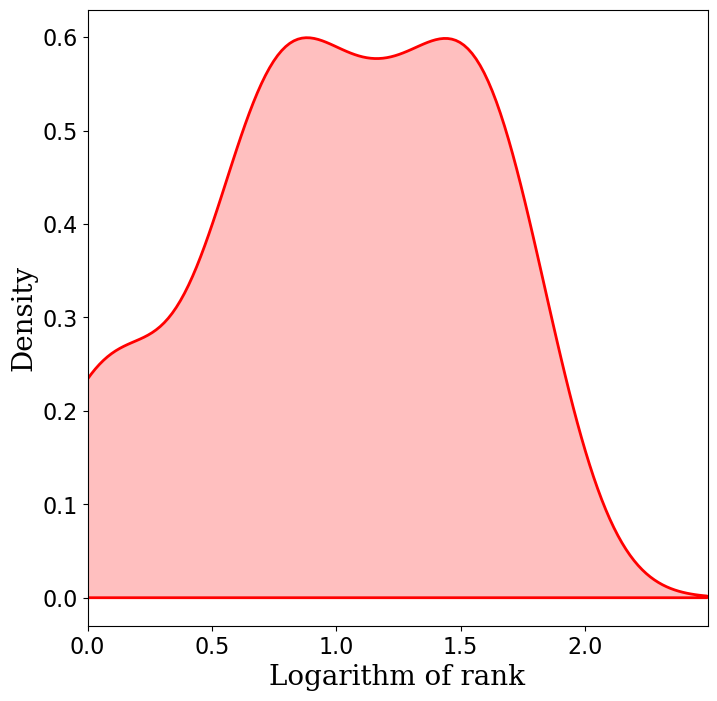

In [13]:
plt.figure(figsize=(8,8))
sns.kdeplot(np.log10(mean_ranking_HEA), shade=True, color="red", linewidth=2)
plt.xlim([0, np.log10(N_CANDIDATE)])
plt.style.use('default')
plt.xlabel("Logarithm of rank", {'fontname': 'serif', 'size': 20})
plt.ylabel("Density", {'fontname': 'serif', 'size': 20})
plt.tick_params(axis='x', which='major', labelsize=16)
plt.tick_params(axis='y', which='major', labelsize=16)
plt.savefig("{}/recommendation_cv.pdf".format(OUTPUT_FOLDER), dpi=300, bbox_inches='tight')
plt.show()